# Author: Babli Dey

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

## Problem - 1
The data for this project (PharmaDrugSales_1.csv) represents 17 years of monthly data on sales of a retail product. You are tasked with the goal of developing a forecasting model that can accurately predict the trend for future years. To achieve the final goal, answer each of the questions below.

In [30]:
pharma_df = pd.read_csv('PharmaDrugSales_1.csv')
pharma_df.head(5)

,Month,Sales
0,7/1/1991,3.526591
1,8/1/1991,3.180891
2,9/1/1991,3.252221
3,10/1/1991,3.611003
4,11/1/1991,3.565869


In [31]:
pharma_df['Month'] = pd.to_datetime(pharma_df['Month'], format='%m/%d/%Y')
pharma_df.set_index('Month',inplace=True)

### 1.	Create a time series of the plot of the data provided.

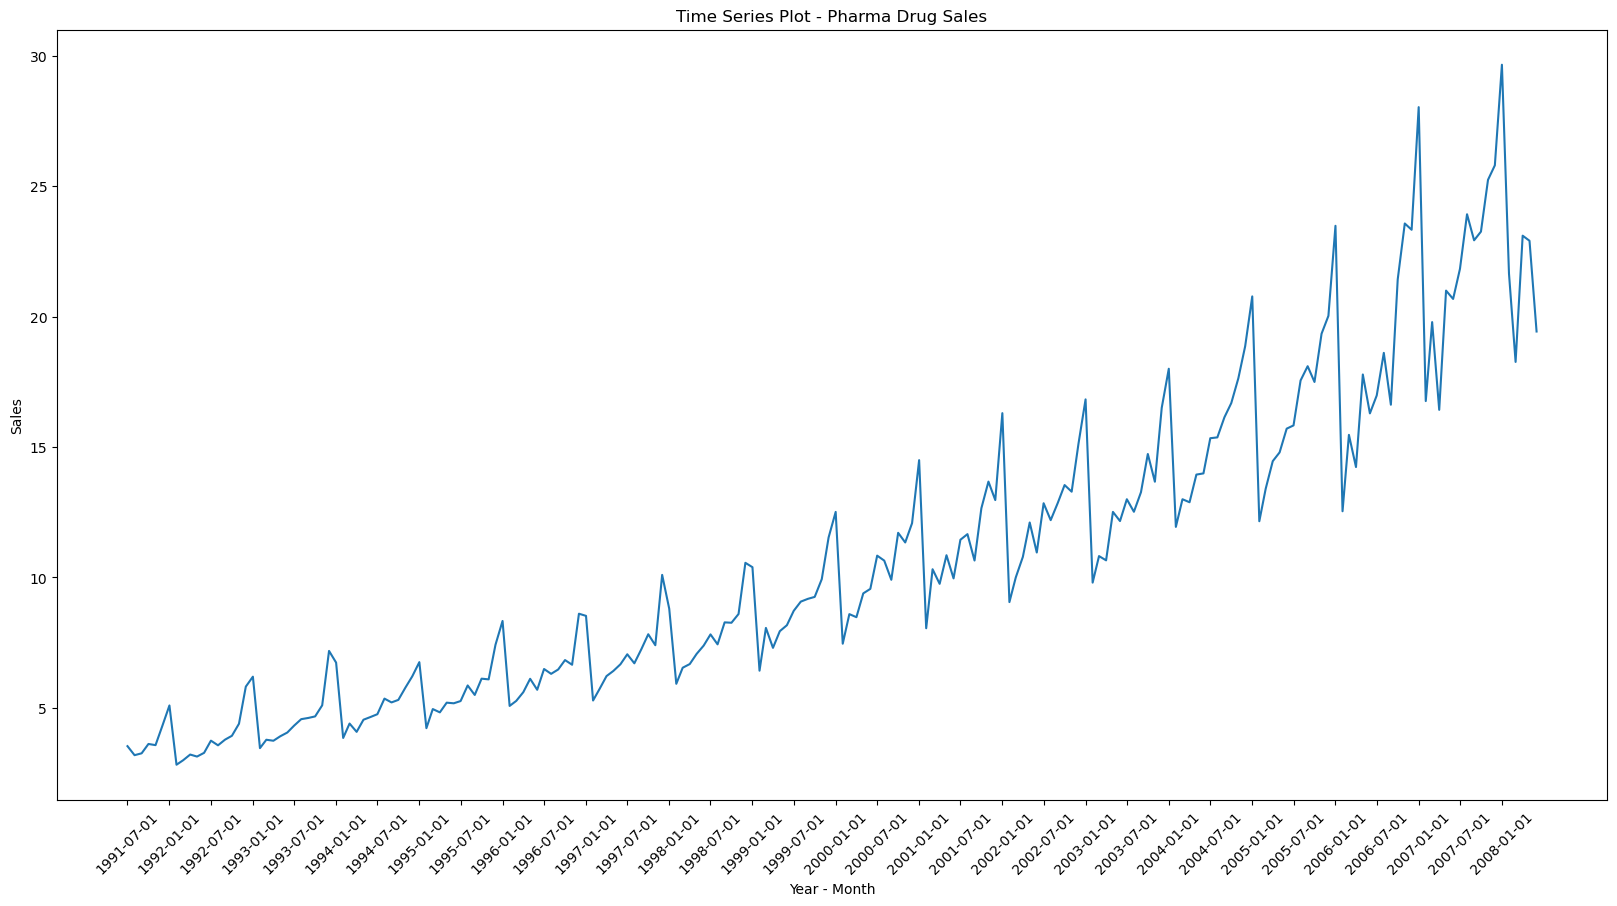

In [32]:
# time series plot for pharma drug sales dataframe

plt.figure(figsize=(20,10))
sns.lineplot(pharma_df, x = pharma_df.index, y = 'Sales')
plt.title('Time Series Plot - Pharma Drug Sales')
plt.xlabel('Year - Month')
plt.ylabel('Sales')
plt.xticks(rotation = 45)
plt.xticks(pharma_df.index[::6])
plt.show()

In [33]:
pharma_df.shape

(204, 1)

### 2.	Plot the autocorrelation function (ACF). From the ACF, what is the seasonal period? (5 pts)


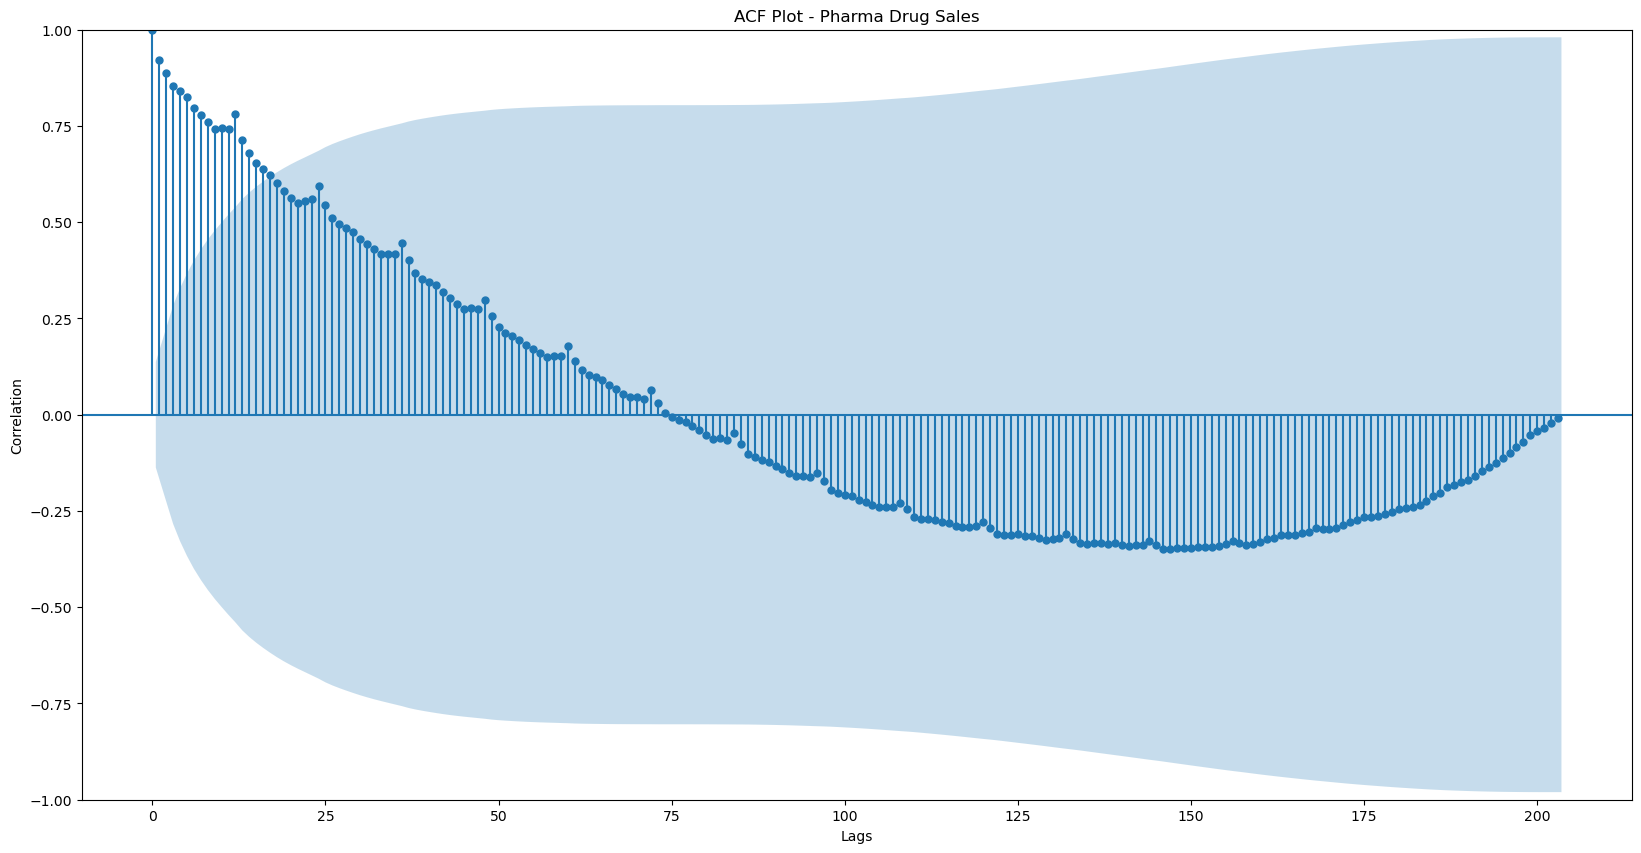

In [34]:
# ACF Plots

fig, ax = plt.subplots(figsize=(20, 10))
plot_acf(pharma_df, lags=203, ax=ax)
ax.set_title('ACF Plot - Pharma Drug Sales')
ax.set_xlabel('Lags')
ax.set_ylabel('Correlation')
plt.show()

<u>Insights:</u><br>
The seasonal period is 12 months i.e 1 year

### 3.	Compute a moving average for the data to determine the trend in the data and overlay on the original time-series plot. What is a suitable choice for the moving average window length? (5 pts)

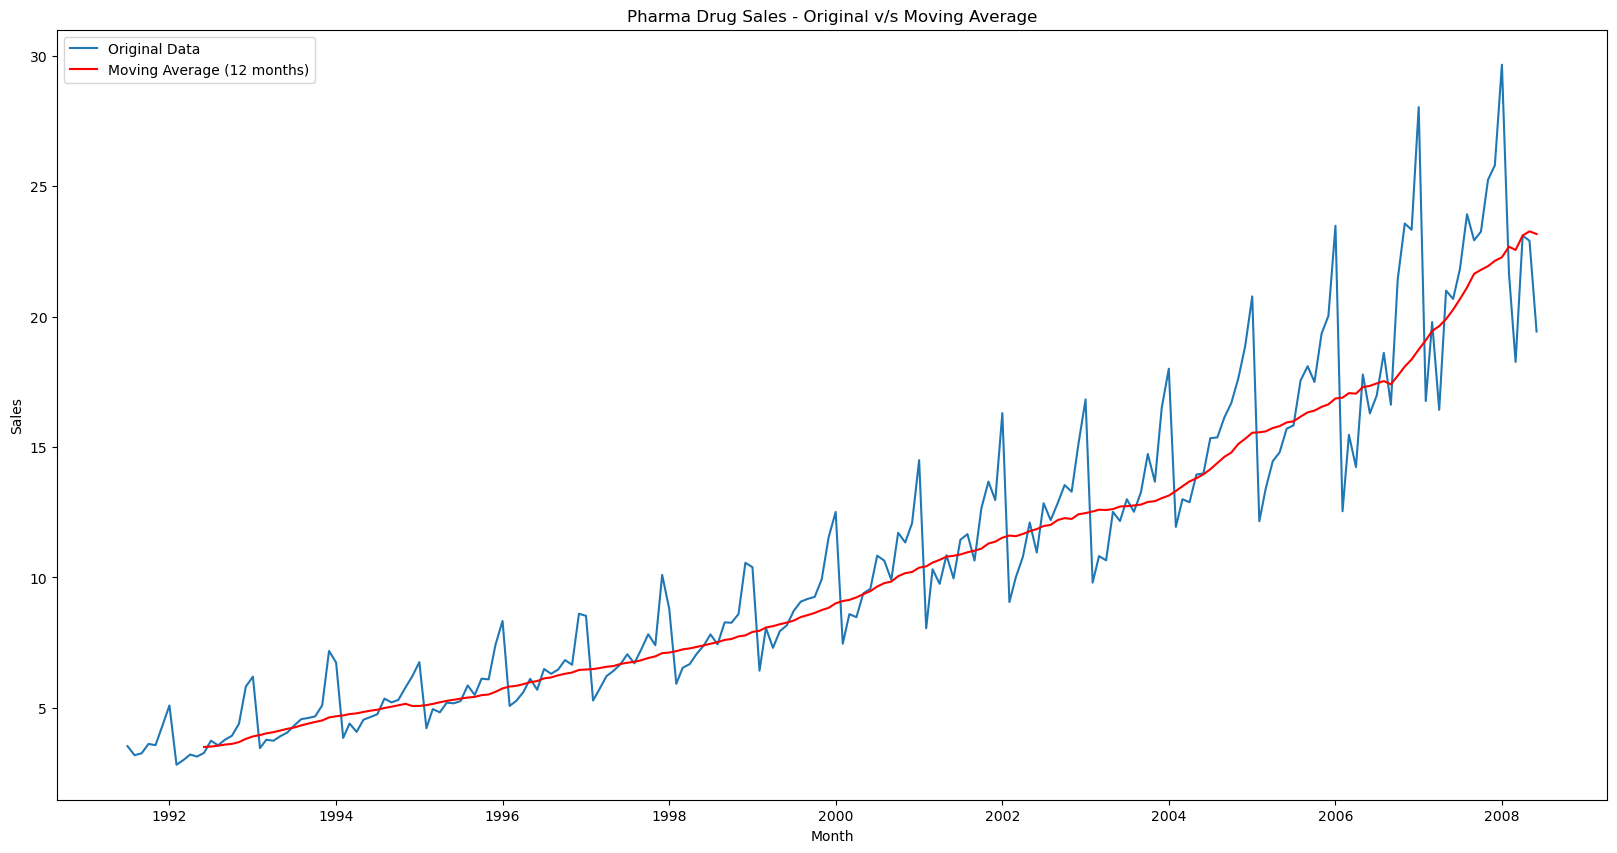

In [35]:
# Compute moving average
moving_average = pharma_df['Sales'].rolling(window=12).mean()

# Plot original data and moving average
plt.figure(figsize=(20, 10))
sns.lineplot(x = pharma_df.index, y = pharma_df['Sales'], label='Original Data')
sns.lineplot(x = pharma_df.index,y=moving_average,color='red', label='Moving Average (12 months)')
plt.title('Pharma Drug Sales - Original v/s Moving Average')
plt.legend()
plt.show()

<u>Insights:</u><br>
The seasonal period is 12 months, hence applying a Moving Average of window 12 is suitable because it eliminates the seaonality component in the data leaving only long term trend behind.

### 4.	Observing the moving average plot in Q3, is the trend line increasing or decreasing? (5 pts)

<u>Insights:</u><br>
Based on observations in Q3 Plot, the moving average (red line) over a 12-month window shows a clear increasing trend. This indicates that over time, the overall sales are rising, even though there are seasonal fluctuations around this trend. The upward slope of the moving average line confirms that the trend in the data is positive.This suggests that the underlying demand or sales for this product has been growing steadily over the years.

### 5a) Compute the first difference of the data and plot the ACF and PACF for the differenced data. [4 pts] 

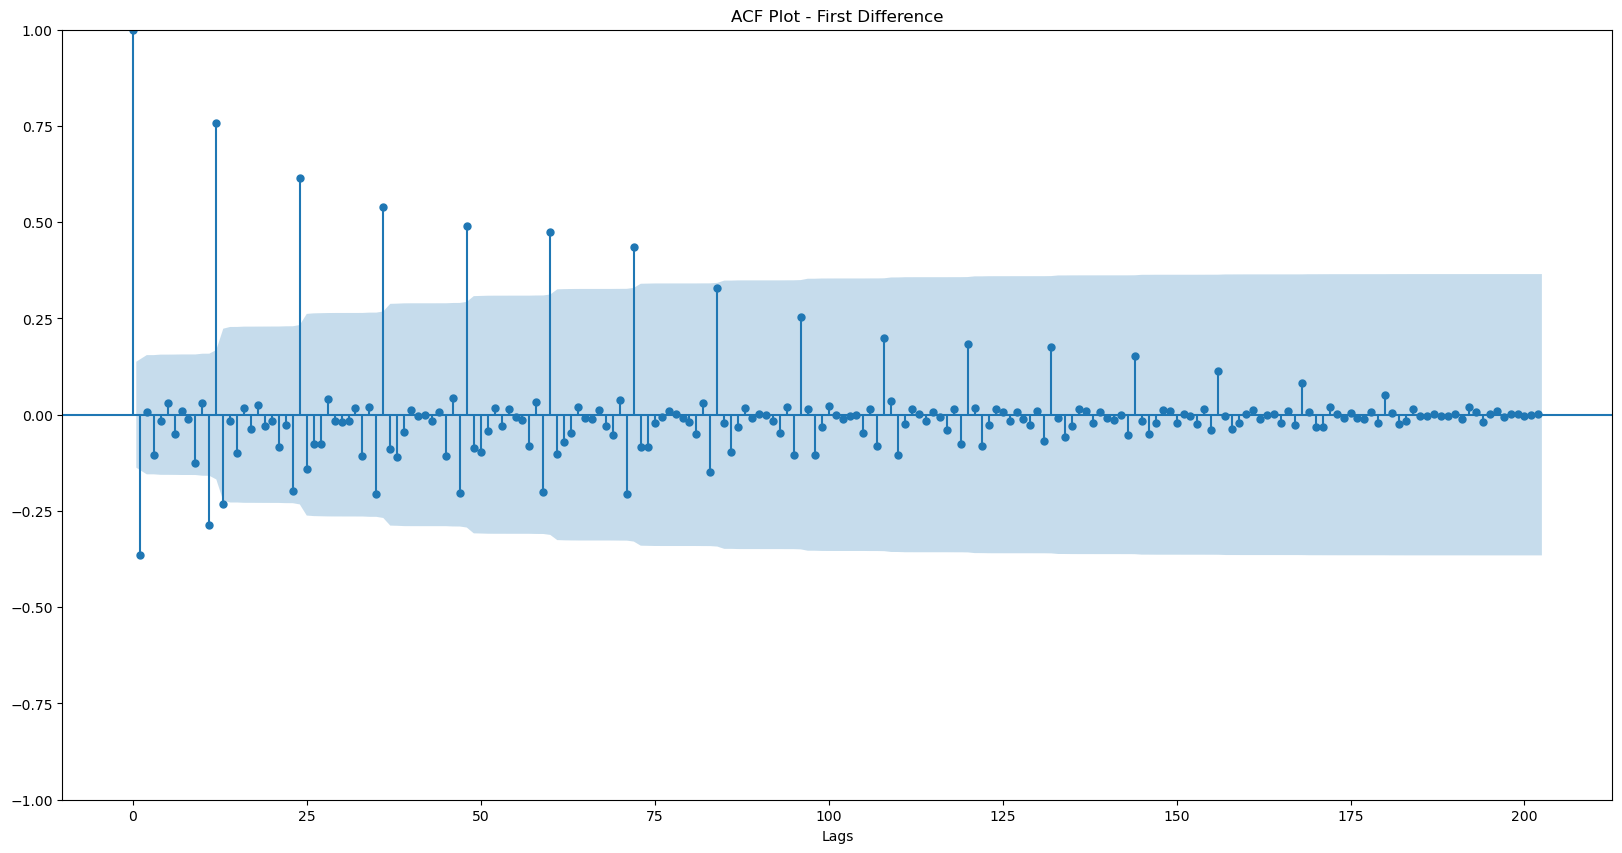

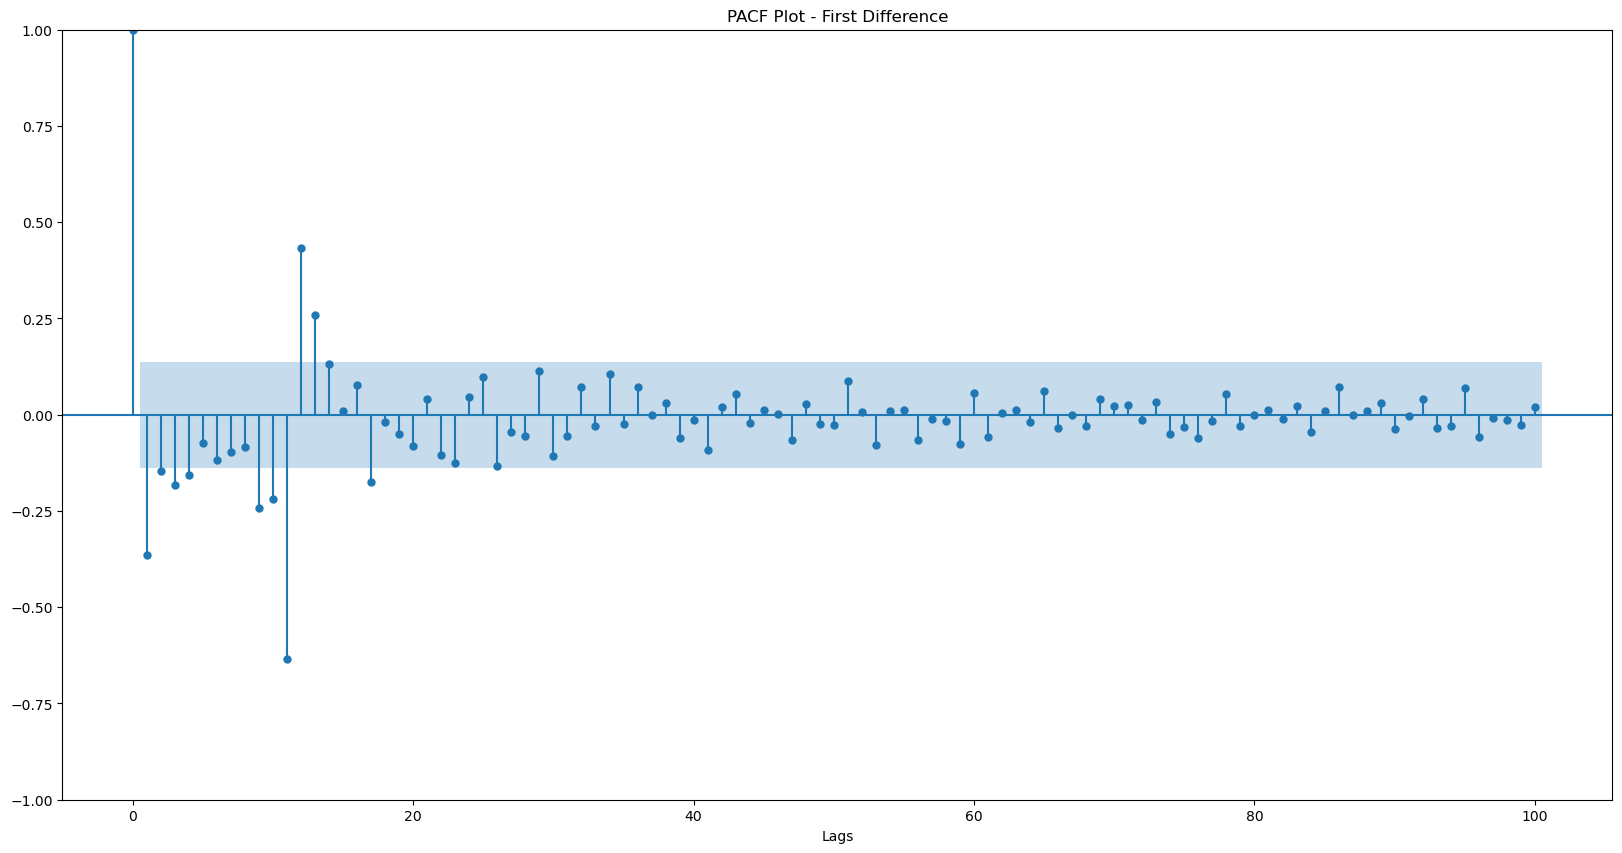

In [36]:
# Compute first difference
first_diff = pharma_df.diff().dropna()

fig, ax = plt.subplots(figsize=(20, 10))
plot_acf(first_diff, lags=202, ax=ax)
plt.title('ACF Plot - First Difference')
plt.xlabel('Lags')

fig, ax = plt.subplots(figsize=(20, 10))
plot_pacf(first_diff, lags=100, ax=ax)
plt.title('PACF Plot - First Difference')
plt.xlabel('Lags')

plt.show()


### 5b) Briefly, describe what change you see in the ACF compared to Q2 [1 pt] ? 

<u>Insights:</u><br>
THe ACF plot in Question 1: The high positive correlations at initial lags indicate a strong autocorrelation, which is typical for non-stationary data.The gradual decline suggests a trend component, and the sinusoidal pattern in the ACF plot hints at seasonality in the data.

The ACF Plot of the difference data in Q5a: The ACF values now oscillate closer to zero, with a few significant spikes at specific lags. This indicates that the differencing has removed much of the trend, potentially making the data more stationary.
Remaining significant spikes (especially at seasonal intervals) could suggest a seasonal component.

### 6.	(5 pts) Using the output from Q5 above, perform a first seasonal difference with the seasonal period you identified in Q2, and plot the ACF and PACF again? 

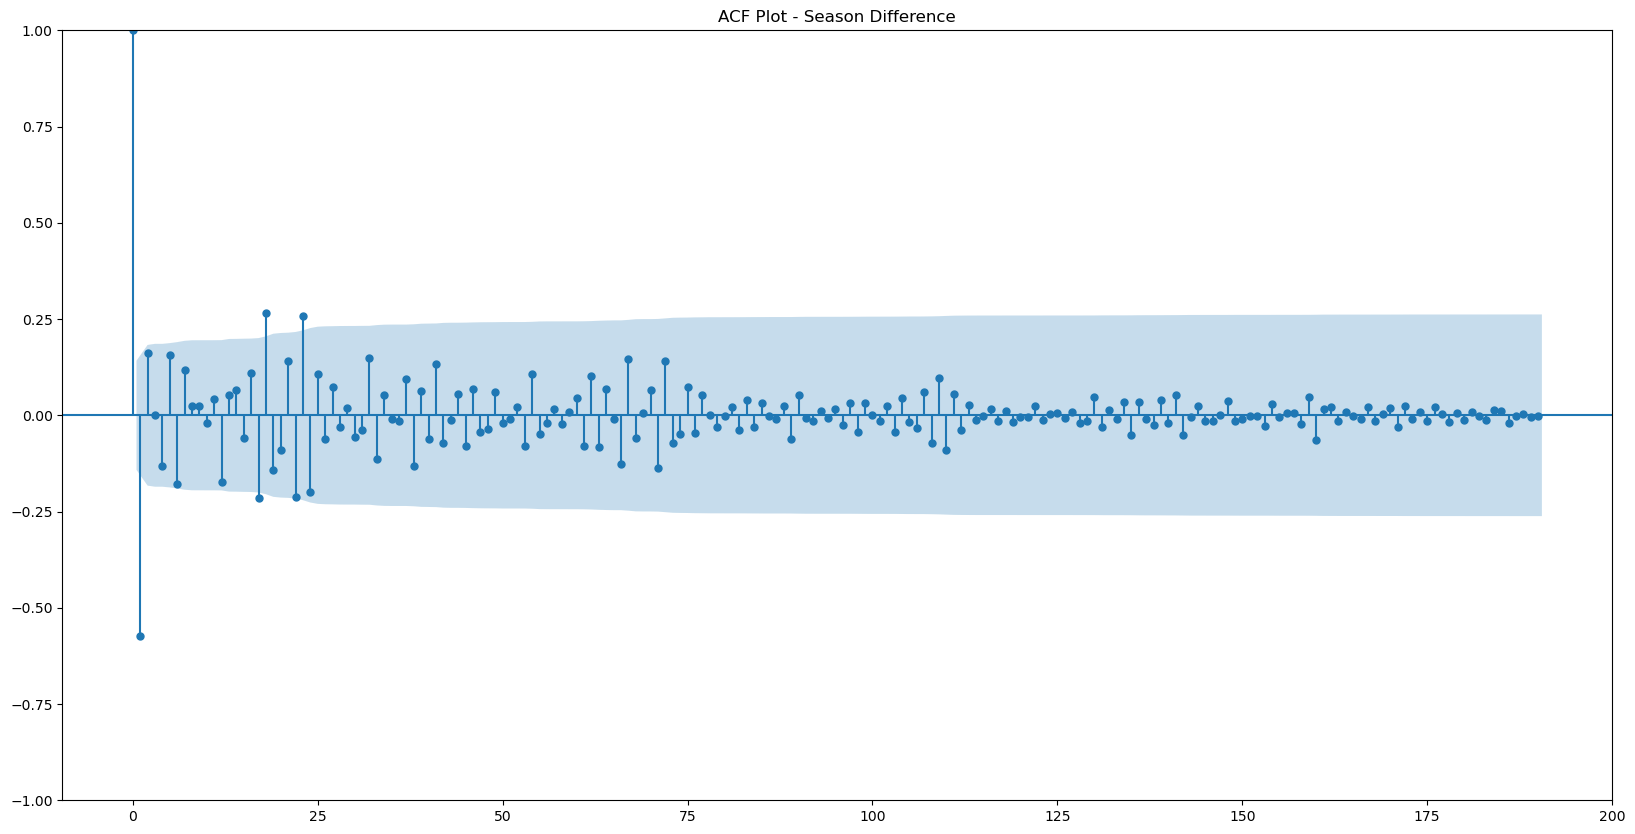

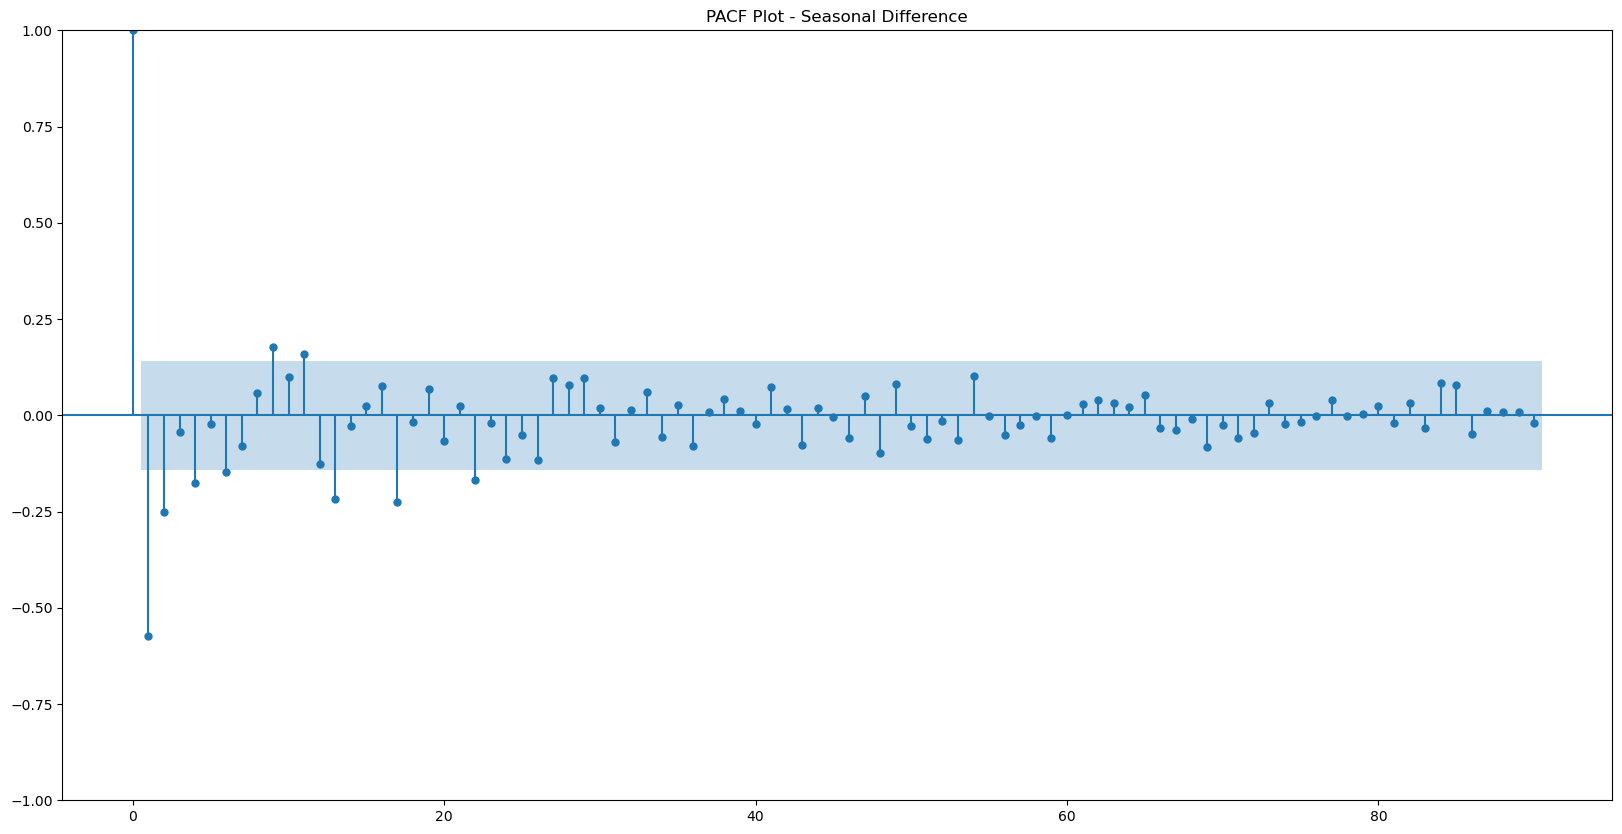

In [37]:
seasonal_diff = first_diff.diff(12).dropna()

fig, ax = plt.subplots(figsize=(20, 10))
plot_acf(seasonal_diff, lags=190, ax=ax)
plt.title('ACF Plot - Season Difference')

fig, ax = plt.subplots(figsize=(20, 10))
plot_pacf(seasonal_diff, lags=90, ax=ax)
plt.title('PACF Plot - Seasonal Difference')

plt.show()

### 7.	Develop a suitable SARIMA model that can be applied on the time series. Use the data from the beginning until June 2005 to develop the model. (20 pts)

In [38]:
# filtering data till June 2005
train_data = pharma_df[:'2005-06-30']

#### a) To develop the model, vary the model parameters for the non-seasonal (p,d,q) and seasonal components (P,D,Q) and calculate the output for each combination of parameters.

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product


p = d = q = range(0, 4)  
P = D = Q = range(0, 4)  
s = 12  

# Generate all combinations of (p,d,q) and (P,D,Q)
parameters = product(p, [1], q, P, [1], Q)
parameters_list = list(parameters)

# function to fit SARIMA and calculate AIC, BIC
results = []
for param in parameters_list:
    try:
        model = SARIMAX(train_data,
                        order=(param[0], param[1], param[2]),
                        seasonal_order=(param[3], param[4], param[5], s))
        result = model.fit(disp=False)
        results.append([param, result.aic, result.bic])
    except:
        continue

#### b) Use an evaluation criteria such as AIC, BIC or sum squared error or mean squared error to determine the best choice of parameters (p,d,q,P,D,Q). Note: AIC and BIC are metrics that is readily output by the ARIMA model. 



In [40]:
# creating a dataframe to conatin all the configs and their AIC BIC Information
results_df = pd.DataFrame(results, columns=['parameters', 'AIC', 'BIC'])
best_model = results_df.sort_values(by='AIC').iloc[0] 

# I have chosen AIC score as the evaluation metric to determine the best choice of parameters
print(f"Best SARIMA parameters based on AIC: {best_model['parameters']}")

Best SARIMA parameters based on AIC: (3, 1, 1, 1, 1, 3)


### 8.	(10 pts) Use the model parameters determined in Q7 above, 



In [41]:
# Test data
test_data = pharma_df['2005-07-01':]

#### a.	(5 pts) Create a forecast for the remaining period (i.e. July 2005 onwards till the end). 


In [42]:
# fitting the model with The best model parameters decided in Q7
selected_model = SARIMAX(train_data,
                        order=(3,1,1),
                        seasonal_order=(1,1,3, s))
model_params=selected_model.fit(display=False)

In [43]:
# forecating values for the remaining period
from sklearn.metrics import mean_squared_error

forecast_steps = len(test_data)
forecast = model_params.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean

#### b.	(3 pts) Create a plot of the predicted values overlaid on the original data. 


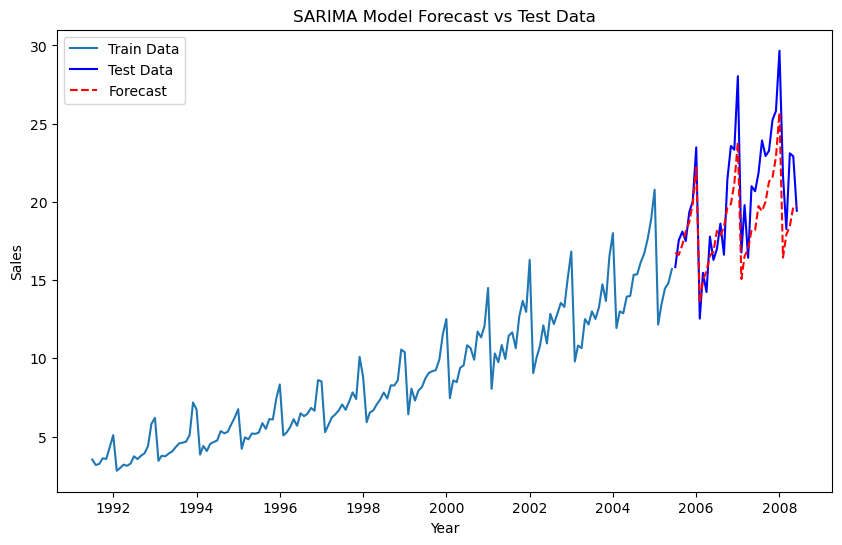

In [44]:
# Plot the forecasted values overlaid on the original data
plt.figure(figsize=(10, 6))
plt.plot(train_data, label="Train Data")
plt.plot(test_data, label="Test Data", color="blue")
plt.plot(test_data.index, forecast_values, color="red", linestyle="--", label="Forecast")
plt.title("SARIMA Model Forecast vs Test Data")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.legend()
plt.show()

#### c.	(2 pts) Compare the forecast with actual values by computing the mean square error. Comment on your observations.

In [45]:
# Calculate Mean Squared Error (MSE) between the forecast and actual test data
mse = mean_squared_error(test_data, forecast_values)
print(f"Mean Squared Error (MSE) of forecast: {mse}")

Mean Squared Error (MSE) of forecast: 6.016316892002378


<u>Insights:</u><br>
To determine the best SARIMA model parameters, I used the Akaike Information Criterion (AIC). The optimal configuration was:
Non-seasonal: (p=3, d=1, q=1)
Seasonal: (P=1, D=1, Q=3) with a seasonal period of 12.
This model achieved a Mean Squared Error (MSE) of 6.0163 on the test data, indicating good forecast accuracy.

Observations:<br>
1. The model captures the overall trend and seasonal pattern well, though it slightly underestimates at seasonal peaks.
2. This suggests that while the model is effective, further fine-tuning could improve accuracy, particularly for peak-season forecasts.

The AIC-selected SARIMA configuration (3,1,1,1,1,3) provides a solid foundation for forecasting but may benefit from adjustments to better capture extreme seasonal variations.

## Problem - 2

In this problem, you will develop a time-series model to analyze Wine consumption from the data file “TotalWine.csv”

In [46]:
wine_df = pd.read_csv('TotalWine.csv')
wine_df.head(5)

,Time (Quarter),TotalWine
0,1,1.486
1,2,1.915
2,3,1.844
3,4,2.808
4,5,1.287


### a)	Plot the time series for TotalWine. What is the seasonal period for this time-series?	

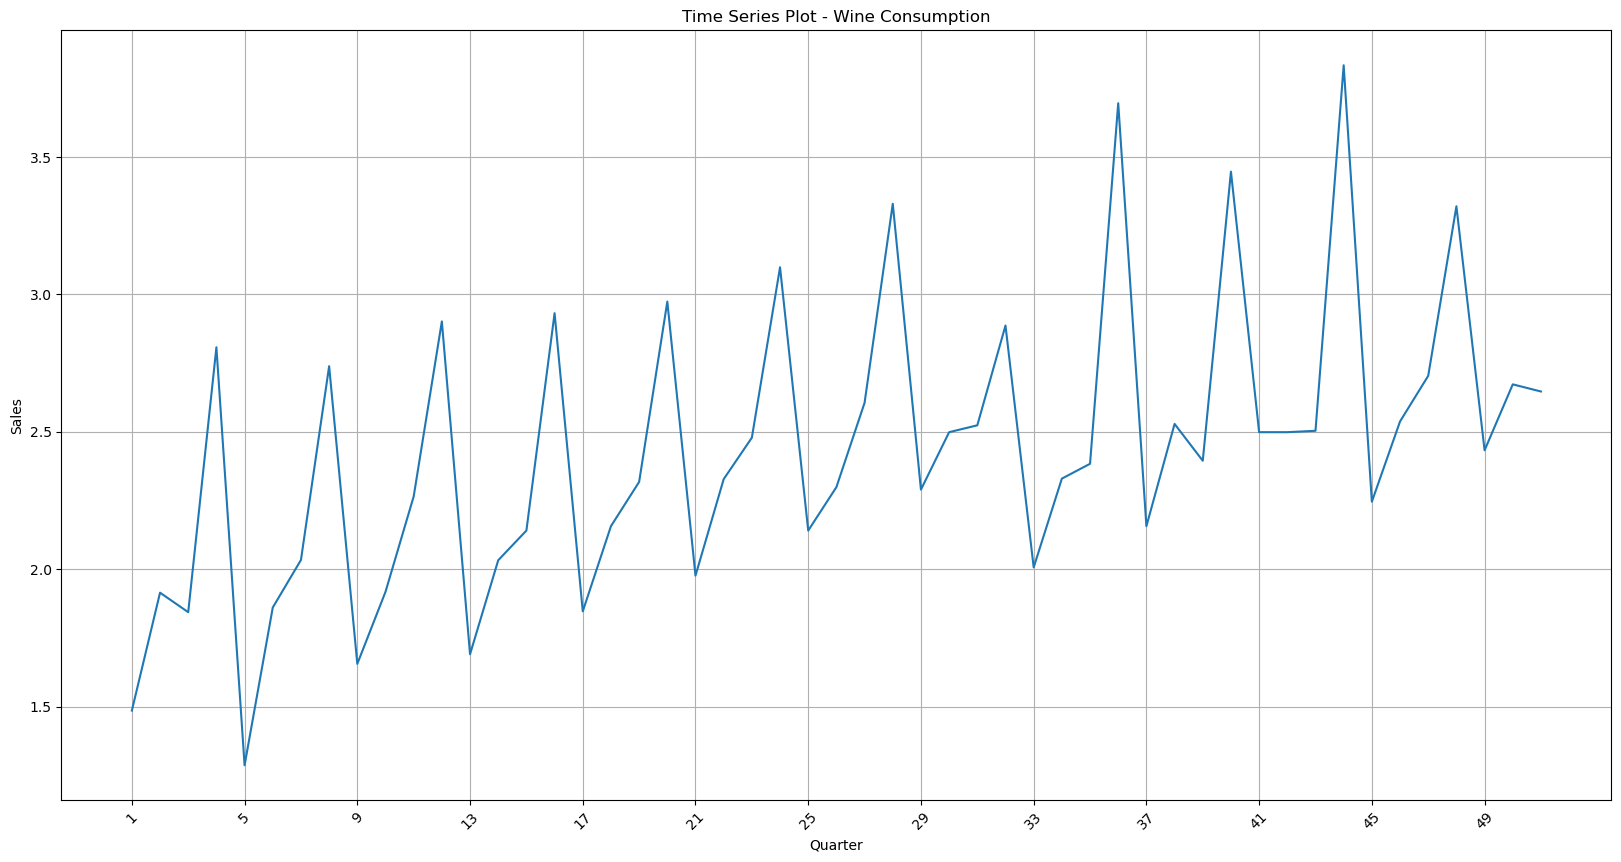

In [47]:
plt.figure(figsize=(20,10))
sns.lineplot(wine_df, x = 'Time (Quarter)', y = 'TotalWine')
plt.title('Time Series Plot - Wine Consumption')
plt.xlabel('Quarter')
plt.ylabel('Sales')
plt.xticks(rotation = 45)
plt.xticks(wine_df['Time (Quarter)'][::4])
plt.grid(True)
plt.show()

<u>Insights:</u><br>
The seasonal period of this time series is 4 Quarters. The cycle repeats at every 4 quarters.

### b)	Apply seasonal differencing to the original time-series. Vary the difference lag from 1, 2, 4, 6. Plot the result for each of these lags. Which of these differences is most suitable to remove the seasonality?

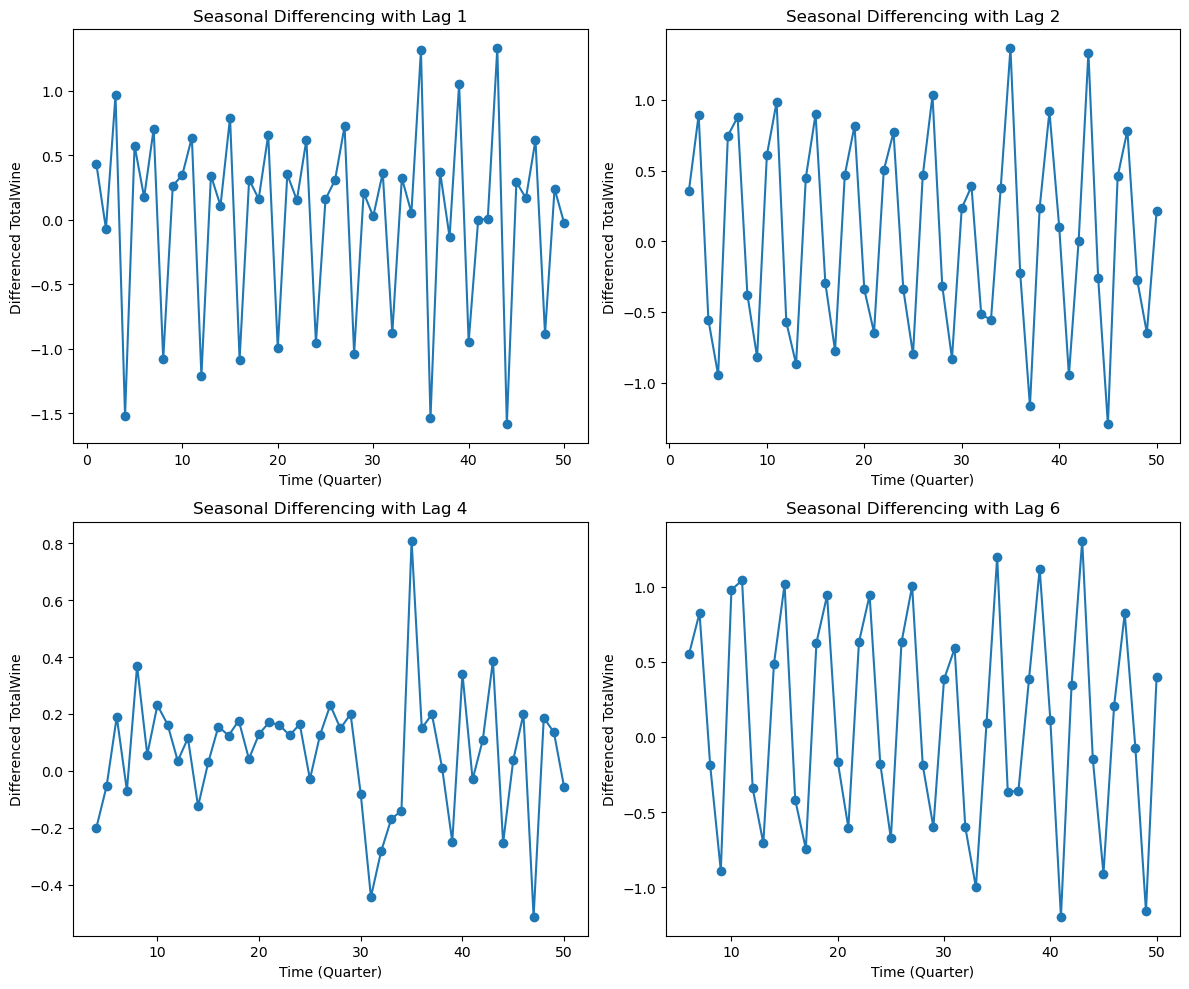

In [48]:
# seasonal lags
lags = [1, 2, 4, 6]
plt.figure(figsize=(12, 10))

for i, lag in enumerate(lags, 1):
    diff_data = wine_df['TotalWine'].diff(lag)
    plt.subplot(2, 2, i)
    plt.plot(diff_data, marker='o')
    plt.title(f'Seasonal Differencing with Lag {lag}')
    plt.xlabel('Time (Quarter)')
    plt.ylabel('Differenced TotalWine')

plt.tight_layout()
plt.show()

<u>Insights:</u><br>
Difference with lag 4 is more suitable to remove seasonality, as rest of the other lag exhibit cyclic patters except the plot with lag 4.

### c)	Compute and plot the Auto-correlation (ACF) function for the original time-series. What is the seasonal period you estimate from the ACF? 	

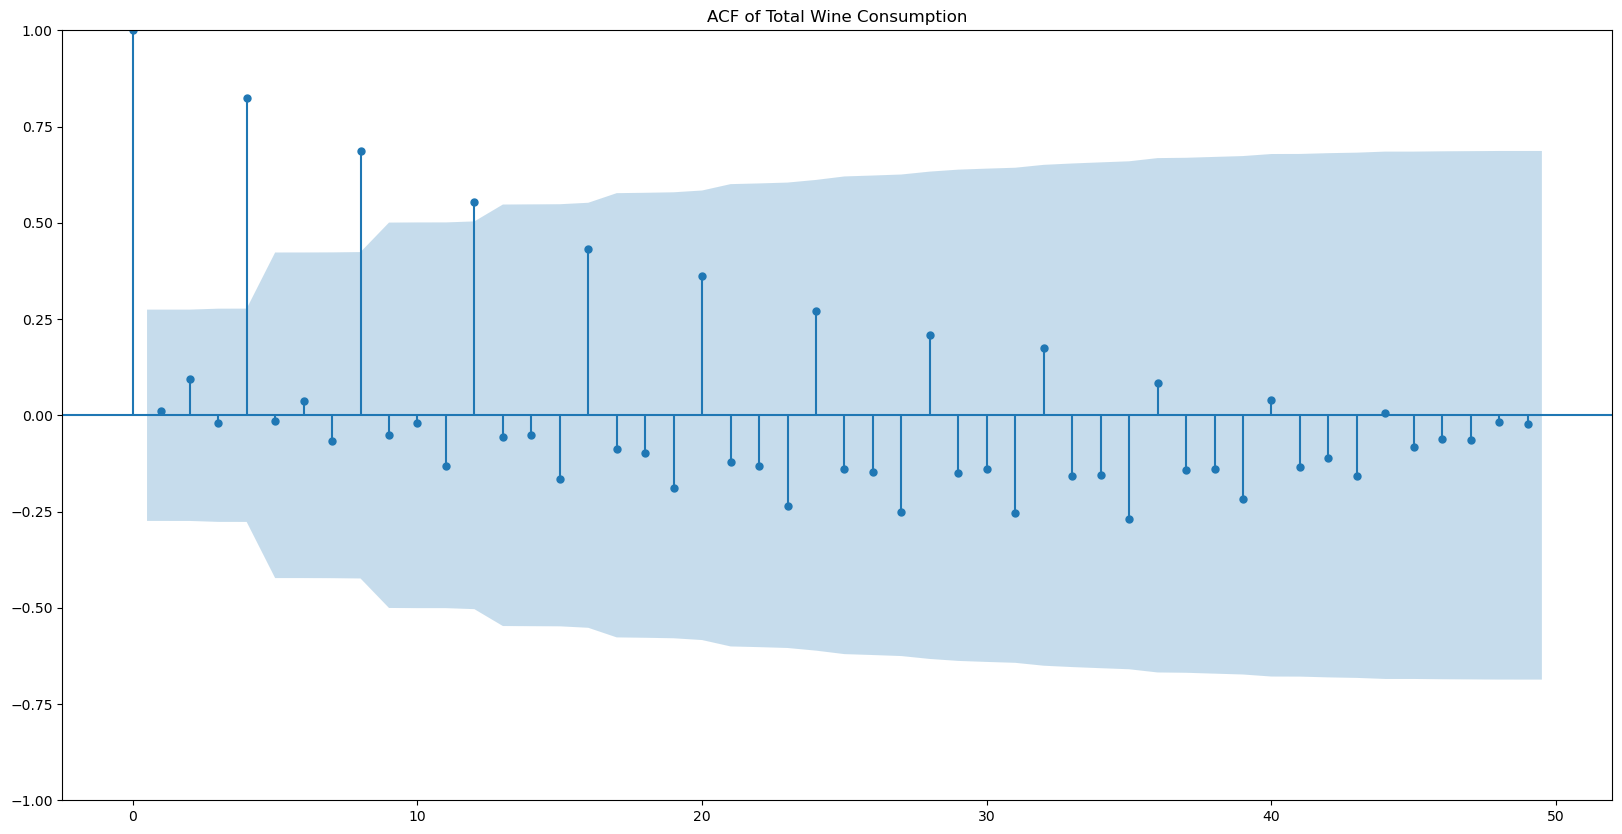

In [49]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_acf(wine_df['TotalWine'], lags=49, ax=ax)
plt.title('ACF of Total Wine Consumption')
plt.show() 

Insights:<br>
The seasonal period estimated from the ACF is 4, because there is significant spikes at every 4 lags.

### d)	Define an AR model using tsa.AR available in statsmodels.api. Determine the optimal order using the “select_order” function. You will need to specify a maximum order p (recommend p=10) to consider and a criterion for deciding which model order is "best". [e.g. You can use AIC as the model selection criteria]

In [50]:
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.ar_model import AutoReg

result = []

for i, lag in enumerate(lags, 1):
    diff_data = wine_df['TotalWine'].diff(lag).dropna()
    # Specify the maximum order p (10 in this case) and the criterion (AIC) for model selection
    order_selection = ar_select_order(diff_data, maxlag=10, ic='aic', old_names=False)

    # Display the selected optimal lag orders
    optimal_order = order_selection.ar_lags
    print("Optimal lag order selected:", optimal_order)

    # Fit the AR model using the optimal lags determined
    model = AutoReg(diff_data, lags=optimal_order).fit()
    result.append(model.summary())

Optimal lag order selected: [1, 2, 3, 4, 5, 6, 7]
Optimal lag order selected: [1, 2, 3, 4, 5, 6]
Optimal lag order selected: [1, 2, 3, 4]
Optimal lag order selected: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [51]:
result

[<class 'statsmodels.iolib.summary.Summary'>
 """
                             AutoReg Model Results                             
 Dep. Variable:              TotalWine   No. Observations:                   50
 Model:                     AutoReg(7)   Log Likelihood                  15.771
 Method:               Conditional MLE   S.D. of innovations              0.168
 Date:                Mon, 28 Oct 2024   AIC                            -13.542
 Time:                        23:36:26   BIC                              2.309
 Sample:                             7   HQIC                            -7.696
                                    50                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
 --------------------------------------------------------------------------------
 const            0.1152      0.031      3.741      0.000       0.055       0.176
 TotalWine.L1    -0.9798      0.119     -8.259      0.000      -

<u>Insights:</u><br>
The AIC Score for Lag 1, 2, 4, 6 is -13.54, -15.250, -18.571 and 4.100 respectvely, based on these scores the best model order is 4 because it's AIC value is the least amongst other lag values.

### e)	Now, evaluate an AR(p) model for the time-series generated after seasonal differencing (using the best lag you found in part b above)(4 pts)



#### i.	use the fit method specifying the optimal lag found above

In [52]:
diff_data = wine_df['TotalWine'].diff(4).dropna()
order_selection = ar_select_order(diff_data, maxlag=10, ic='aic', old_names=False)
optimal_order = order_selection.ar_lags
model = AutoReg(diff_data, lags=optimal_order).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              TotalWine   No. Observations:                   47
Model:                     AutoReg(4)   Log Likelihood                  15.286
Method:               Conditional MLE   S.D. of innovations              0.170
Date:                Mon, 28 Oct 2024   AIC                            -18.571
Time:                        23:36:26   BIC                             -8.004
Sample:                             4   HQIC                           -14.674
                                   47                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1189      0.031      3.850      0.000       0.058       0.179
TotalWine.L1    -0.0033      0.116     -0.029      0.977      -0.230       0.223
TotalWine.L2     0.0507      0.115      0.440      0.660      -0.175       0.277
TotalWine.L3     0.0526      0.115      0.456      0.648      -0.173       0.279
TotalWine.L4    -0.6934      0.123     -5.629      0.000      -0.935      -0.452
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.7680           -0.7622j            1.0820           -0.3756
AR.2           -0.7680           +0.7622j            1.0820            0.3756
AR.3            0.8059           -0.7630j            1.1098           -0.1207
AR.4            0.8059           +0.7630j            1.1098            0.1207
-----------------------------------------------------------------------------
"""

#### ii.	use the predict method to generate values starting at the optimal lag

In [53]:
start = 4  
end = len(diff_data) - 1
predictions = model.predict(start=start, end=end)

#### iii.	plot the predicted results and the corresponding seasonally differenced time-series

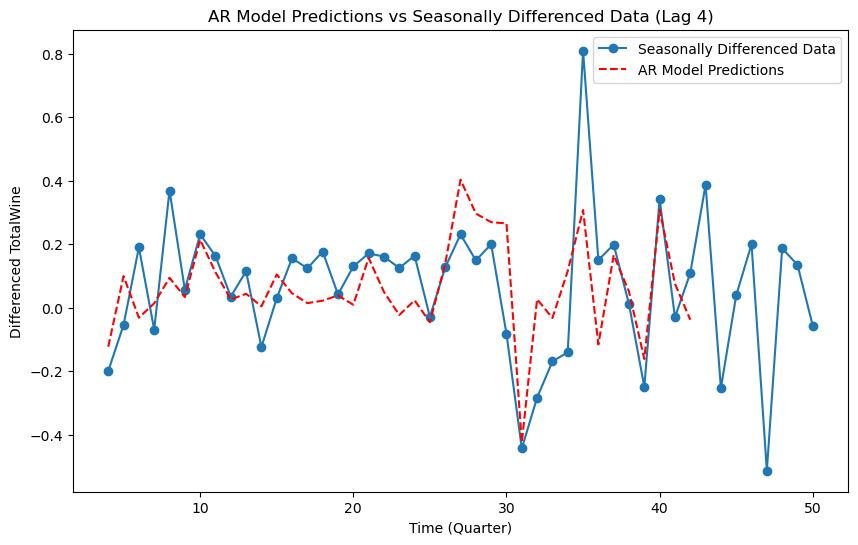

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(diff_data, label='Seasonally Differenced Data', marker='o')
plt.plot(range(start, end + 1), predictions, color='red', linestyle='--', label='AR Model Predictions')
plt.title('AR Model Predictions vs Seasonally Differenced Data (Lag 4)')
plt.xlabel('Time (Quarter)')
plt.ylabel('Differenced TotalWine')
plt.legend()
plt.show()

#### iv.	Calculate the Mean Absolute Error (MAE) by comparing the predicted results with the seasonally differenced data.

In [55]:
from sklearn.metrics import mean_absolute_error

valid_indices = ~np.isnan(predictions)

# Filter out NaNs from both predictions and corresponding actual values
filtered_predictions = predictions[valid_indices]
filtered_actual_values = diff_data[start:][valid_indices]

# Calculate Mean Absolute Error (MAE) on filtered data
mae = mean_absolute_error(filtered_actual_values, filtered_predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.26398337732776
